In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import generate_objects, BunchTracker, track, compare_traces, compare_projections, Machine

from PyHEADTAIL.feedback.feedback import OneboxFeedback, Kicker, PickUp
from PyHEADTAIL.feedback.processors.multiplication import ChargeWeighter
from PyHEADTAIL.feedback.processors.linear_transform import Averager
from PyHEADTAIL.feedback.processors.misc import Bypass
from PyHEADTAIL.feedback.processors.register import Register, TurnDelay, UncorrectedDelay

np.random.seed(0)

PyHEADTAIL v1.13.0.17
(dirty git work tree)


--> Use the longitudinal_tracking module instead.

PyHEADTAIL_feedback v0.2




/home/lmether/Desktop/PyHEADTAIL_multibunch_merge/PyHEADTAIL_develop/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


# 002 Separate pickup and kicker

In this test/example, a pickup and a kicker are located separately in the one turn map. The used signal processing follows the ideal bunch-by-bunch feedback presented in the previous test (001_ideal_feedbacks.ipynb).

## Basic parameters and elements for the simulations

In [2]:
n_macroparticles = 10000
n_slices = 20
n_segments = 5
n_sigma_z = 3
# n_sigma_z = 6

n_turns = 50

# Longitudinal motion of the bunch is not taken into account by default, but it can be included by uncommenting
# the line below
machine = Machine(n_segments= n_segments)
# machine = Machine(Q_s = 0.0020443)

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(machine, n_macroparticles, n_slices,n_sigma_z)

*** I am rank 0 - my buckets are [0]


## Initial bunch kick
Creates an artificially (slice-by-slice) kicked bunch, which will be damped by using different feedback systems. 

In [3]:
slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

# Random slice kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]

# A bunch kick
# kick_x = 0.003*np.ones(n_slices)
# kick_y = 0.003*np.ones(n_slices)

## Feedback settings

In [4]:
feedback_gain = 0.1
# feedback_gain = (0.1,0.4)

# delay (a number of turns) before the pickup signal is used to the correction kick calculations.
delay = 1

# a number of values used to calculate the correct signal
n_values = 2

## Reference data
Tracks a bunch by using an ideal bunch-by-bunch feedback system presented in the previous test (001_ideal_feedbacks.ipynb). This data are used as a reference data for the feedback models including delay and separate pickup(s) and kicker(s)

In [5]:
bunch_ref_data = copy.deepcopy(bunch_ref)
tracker_ref_data = BunchTracker(bunch_ref_data)
slicer_ref_data = copy.deepcopy(slicer_ref)

processors_bunch_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]
processors_bunch_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]

feedback_map = OneboxFeedback(feedback_gain,slicer_ref_data,processors_bunch_x,processors_bunch_y)
one_turn_map = [i for i in trans_map] + [feedback_map] #  + [long_map]

track(n_turns, bunch_ref_data,one_turn_map ,tracker_ref_data)

## Betatron motion in a feedback model 

Because pickup(s) and kicker(s) are often located in different locations in the accelerator and there is a delay between pickup reading and correction kick, betatron motion of a bunch is an essential part of a feedback system. However, because the betatron motion correction algorithms work usually quite well, implementations of a turn delay or a separate pickup and kicker into the feedback model does not often affect simulation results if a simplified model for a damper system is used and the gain value is low. 

Because of the finite signal processing time required by the damper system, there is often one turn delay between pickup readings and correction kicks. Betatron phase advance of one turn delay is much longer than the physical separation of the pickup and the kicker and, therefore, the feedback model can be often simplified by taking only into account the one turn delay between the pickup reading and the correction kick instead of implementing a separate pickup and kicker into the model

### Turn delay

Turn delay can be implemented two different ways: by rotating betatron phase before the signal processing or using a realistic betatron correction algorithm in the signal processing model.

The most ideal, but more unrealistic way is to rotate a pickup signal to the correct betatron phase before the signal processing by using both x and x' coordinates of the beam. This can be implemented to the feedback model by adding an UncorrectedDelay() to the signal processor chain and giving the required betatron phase rotation angle to the OneboxFeedback object. 

#### Case 1: Artificial phase rotation

This is close to the real-life situation where oscillations are measured by using two pickups and the betatron phase advances differences between the pickups and the kicker are perfectly known. 

In [6]:
bunch_delay_rotation = copy.deepcopy(bunch_ref)
tracker_delay_rotation = BunchTracker(bunch_delay_rotation)
slicer_delay_rotation = copy.deepcopy(slicer_ref)

processors_delay_rotation_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    UncorrectedDelay(delay)
]
processors_delay_rotation_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    UncorrectedDelay(delay)
]

phase_rotation_x = 0.
phase_rotation_y = 0.

# one turn delay in betatron phase advances
phase_rotation_x += delay * 2. * pi * machine.Q_x
phase_rotation_y += delay * 2. * pi * machine.Q_y

# additional rotation required by transformation from pickup displacement signalto kicker divergence signal
phase_rotation_x += pi/2.
phase_rotation_y += pi/2.

feedback_map = OneboxFeedback(feedback_gain,slicer_delay_rotation,
                              processors_delay_rotation_x,processors_delay_rotation_y,
                              phase_x=phase_rotation_x, phase_y=phase_rotation_y,
                              beta_x=machine.beta_x, beta_y=machine.beta_y,
                              pickup_axis='displacement', kicker_axis='divergence')
one_turn_map = [feedback_map] + [i for i in trans_map] #  + [long_map]

track(n_turns, bunch_delay_rotation,one_turn_map,tracker_delay_rotation)

#### Case 2: Correction algorithm

Different betatron correction algorithms can be implemented by adding a *TurnDelay(...)* or a *TurnFIRFilter(...)* to the signal processing chain. The object *TurnDelay(...)* stores signals from a number of turns given in parameters *delay* and *n_values*. The return signal is calculated from the stored signals after the delay by using different algorithms. 

The different algorithms have been programmed into the framework by using *combiner* objects. Combiner objects read signals from register objects and calculate the correct signal by using an algorithm programmed into the combiner. The same combiner objects are utilized both in the cases of one turn delay and separate pickups and kickers, but in the case of the one turn delay, this mechanism is hidden into the TurnDelay object in order to simplify the user interface.

The combiner type can be specified by giving an input parameter *combiner* into the *TurnDelay(...)*. At the moment available combiner types are a Hilbert phase shifter (*'hilbert'*), a cosine sum algorithm  (*'cosine_sum'*) and a vector sum algorithm (*'vector_sum'*). The vector sum combiner is used by default because it gives almost ideal correction in most of the cases.

In [7]:
bunch_delay_algorithm = copy.deepcopy(bunch_ref)
tracker_delay_algorithm = BunchTracker(bunch_delay_algorithm)
slicer_delay_algorithm = copy.deepcopy(slicer_ref)



processors_delay_algorithm_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    TurnDelay(delay, machine.Q_x, n_values,additional_phase_advance=0.)
]
processors_delay_algorithm_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    TurnDelay(delay, machine.Q_y, n_values,additional_phase_advance=0.)
]

feedback_map = OneboxFeedback(feedback_gain,slicer_delay_algorithm,
                              processors_delay_algorithm_x,processors_delay_algorithm_y)
one_turn_map = [feedback_map] + [i for i in trans_map] # + [long_map]

track(n_turns, bunch_delay_algorithm,one_turn_map,tracker_delay_algorithm)


### Separate pickup and kicker

Pickups and kickers can be added separately to the one turn map by using a *Pickup(...)* and *Kicker(...)* object. Because of signal and kick strengths depend on the values of the beta function and betatron phase advance on the pickup and kicker locations, these values must be given as input parameters to *Pickup(...)* and *Kicker(...)* objects. 


In [8]:
# Beta function values in the pickup and the kicker locations
pickup_beta_x = machine.beta_x
pickup_beta_y = machine.beta_y

kicker_beta_x = machine.beta_x
kicker_beta_y = machine.beta_y

The values of betatron phase advances are from an arbitrary reference point of the accelerator to the pickup and the kicker locations. In this example, the reference point is chosen to be the start point of the one turn map. Because the one turn map is divided into equally length segments in this example, the phase advances of the pickup and the kicker are determined only by their locations in the one turn map, i.e.

In [9]:
pickup_location_x = 1.*2.*pi/float(n_segments)*machine.Q_x
pickup_location_y = 1.*2.*pi/float(n_segments)*machine.Q_y

kicker_location_x = 2.*2.*pi/float(n_segments)*machine.Q_x
kicker_location_y = 2.*2.*pi/float(n_segments)*machine.Q_y

The signal between a pickup and a kicker is transferred by using *Register(...)* objects. A *Register* object in the signal processing chain of the pickup stores signals from the pickup. A reference to the register is given as an input parameter to the *Kicker* object. In the kicker object, signals from different registers are combined by using a combiner object. The betatron correction algorithm/combiner can be specified with a *combiner* parameter to the kicker. The combiner options are the same as for the *TurnDelay(...)* object and *'vector_sum'* is the default option as well.

In [10]:
processors_pickup_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(1, machine.Q_x, delay)
]
processors_pickup_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(1, machine.Q_y, delay)
]

As in the case of the turn delay, betatron phase advance correction can be implemented two different ways; rotating the signals artificially directly in the pickup object before the signal processing or using a combiner object including a realistic betatron correction algorithm.

#### Case 1: Artificial phase rotation in the pickup object

By rotating the signals directly in the pickup object, the total phase rotation angle must be calculated separately, i.e.

In [11]:
phase_rotation_x = 0.
phase_rotation_y = 0.

# rotation required by one turn delay
phase_rotation_x +=  (delay) * 2. * pi * machine.Q_x
phase_rotation_y +=  (delay) * 2. * pi * machine.Q_y

# rotation required by transformation from pickup displacement signal into kicker divergence signal
phase_rotation_x += pi/2.
phase_rotation_y += pi/2.

# rotation required by the location difference between the pickup and the kicker
phase_rotation_x += kicker_location_x - pickup_location_x
phase_rotation_y += kicker_location_y - pickup_location_y

After that initial phase, rotation angles are given into pickup object and the pickup and the kicker objects are added to correct locations of the one turn map. *Dummy* combiner must be used in the kicker object because the betatron phase correction is already taken into account in the pickup object

In [12]:
bunch_separate_rotation = copy.deepcopy(bunch_ref)
tracker_separate_rotation = BunchTracker(bunch_separate_rotation)
slicer_separate_rotation = copy.deepcopy(slicer_ref)

# The map element is created by giving a slicer object, the signal processors and the beam parameters as input parameters
pickup_map = PickUp(slicer_separate_rotation, processors_pickup_x, processors_pickup_y,
                    pickup_location_x, pickup_beta_x, pickup_location_y, pickup_beta_y,
                    phase_x=phase_rotation_x, phase_y=phase_rotation_y)

# In this example, the signals are not modified in the kicker, i.e. only bypass processors are used
processors_kicker_x = [Bypass()]
processors_kicker_y = [Bypass()]

# A list of references to registers from the pickup signal processsor chains
registers_x = [processors_pickup_x[-1]]
registers_y = [processors_pickup_y[-1]]

kicker_map = Kicker(feedback_gain, slicer_separate_rotation, processors_kicker_x, processors_kicker_y,
                    registers_x, registers_y, kicker_location_x, kicker_beta_x, kicker_location_y, kicker_beta_y,
                    combiner='dummy')

one_turn_map = [trans_map[0]] + [pickup_map] + [trans_map[1]] + [kicker_map]
for element in trans_map[2:]:
    one_turn_map += [element]
# one_turn_map += [long_map]
      
track(n_turns, bunch_separate_rotation, one_turn_map, tracker_separate_rotation)

#### Case 2: Correction algorithm

The use of correction algorithm is simpler than the artificial phase rotation in the pickup object because the phase rotation must not be calculated separately. The code is exactly same, expect the phase rotations are not given to the pickup objects and another option than *'dummy'* is used for the combiner in the kicker object.

In [13]:
bunch_separate_algorithm = copy.deepcopy(bunch_ref)
tracker_separate_algorithm = BunchTracker(bunch_separate_algorithm)
slicer_separate_algorithm = copy.deepcopy(slicer_ref)

# Exactly same signal processors as in the previous example are used in the pickup
processors_pickup_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_x, delay)
]
processors_pickup_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_y, delay)
]

pickup_map = PickUp(slicer_separate_algorithm,processors_pickup_x,processors_pickup_y, pickup_location_x, pickup_beta_x,
                 pickup_location_y, pickup_beta_y)


# In this example, the signals are not modified in the kicker, i.e. only bypass processors are used
processors_kicker_x = [Bypass()]
processors_kicker_y = [Bypass()]

# A list of references to registers from the signal processors(s) of the pickup(s)
registers_x = [processors_pickup_x[-1]]
registers_y = [processors_pickup_y[-1]]

kicker_map = Kicker(feedback_gain, slicer_separate_algorithm, processors_kicker_x, processors_kicker_y,
                    registers_x, registers_y, kicker_location_x, kicker_beta_x, kicker_location_y, kicker_beta_y)

one_turn_map = [trans_map[0]] + [pickup_map] + [trans_map[1]] + [kicker_map]
for element in trans_map[2:]:
    one_turn_map += [element]
# tone_turn_map += [long_map]
    
track(n_turns, bunch_separate_algorithm,one_turn_map,tracker_separate_algorithm)

## Results comparison

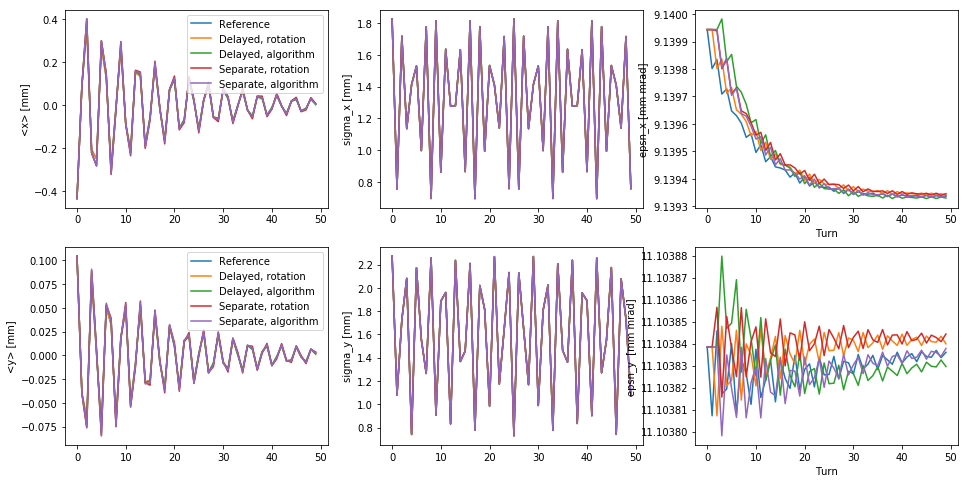

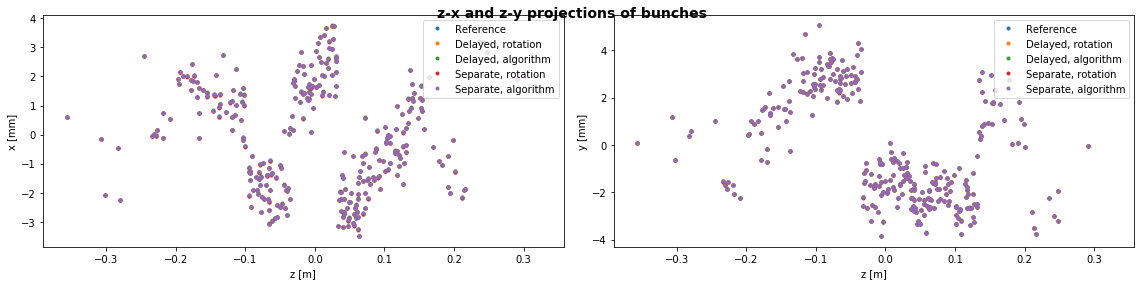

In [14]:
compare_traces([tracker_ref_data,tracker_delay_rotation,tracker_delay_algorithm,
                tracker_separate_rotation, tracker_separate_algorithm],
               ['Reference', 'Delayed, rotation', 'Delayed, algorithm', 'Separate, rotation', 'Separate, algorithm'])
compare_projections([bunch_ref_data,bunch_delay_rotation,bunch_delay_algorithm,
                bunch_separate_rotation, bunch_separate_algorithm],
               ['Reference', 'Delayed, rotation', 'Delayed, algorithm', 'Separate, rotation', 'Separate, algorithm'])

Jani Komppula, CERN, 2017